In [2]:
import gmsh
import numpy as np
import meshio
import matplotlib.pyplot as plt

In [3]:
# Domain parameters
seaside = 10  # Length of the domain in x-direction
roof = 20  # Length of the domain in y-direction
top = 15
wall = 7


In [17]:
gmsh.initialize()
gmsh.model.add("Breakwater")

# Tag offset
tag = 1

# Mesh size
lc = 1

# Outer rectangle points
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc, tag); tag += 1
p2 = gmsh.model.geo.addPoint(0, top, 0, lc, tag); tag += 1
p3 = gmsh.model.geo.addPoint(wall, top, 0, lc, tag); tag += 1
p4 = gmsh.model.geo.addPoint(wall, roof, 0, lc, tag); tag += 1
p5 = gmsh.model.geo.addPoint(seaside, roof, 0, lc, tag); tag += 1
p6 = gmsh.model.geo.addPoint(seaside, 0, 0, lc, tag); tag += 1

# Outer rectangle lines
l_a = gmsh.model.geo.addLine(p1, p2)
l_b = gmsh.model.geo.addLine(p2, p3)
l_c = gmsh.model.geo.addLine(p3, p4)
l_d = gmsh.model.geo.addLine(p4, p5)
l_e = gmsh.model.geo.addLine(p5, p6)
l_f = gmsh.model.geo.addLine(p6, p1)

# Define surface with a hole
outer_loop = gmsh.model.geo.addCurveLoop([l_a, l_b, l_c, l_d, l_e, l_f])
surface = gmsh.model.geo.addPlaneSurface([outer_loop])

gmsh.model.geo.synchronize()

# # Define physical group for the interior domain
interior_tag = 3  # Assign a physical group ID
gmsh.model.addPhysicalGroup(2, [surface], interior_tag)  # 2 corresponds to surface dimension

# # Define physical boundary for the left vertical side (l4)
left_side_tag = 2  # Assign a physical group ID
right_side_tag = 4  # Assign a physical group ID
gmsh.model.addPhysicalGroup(1, [l_f, l_e], right_side_tag)  # 1 corresponds to curve dimension


# Generate the mesh
# gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("Breakwater.msh")

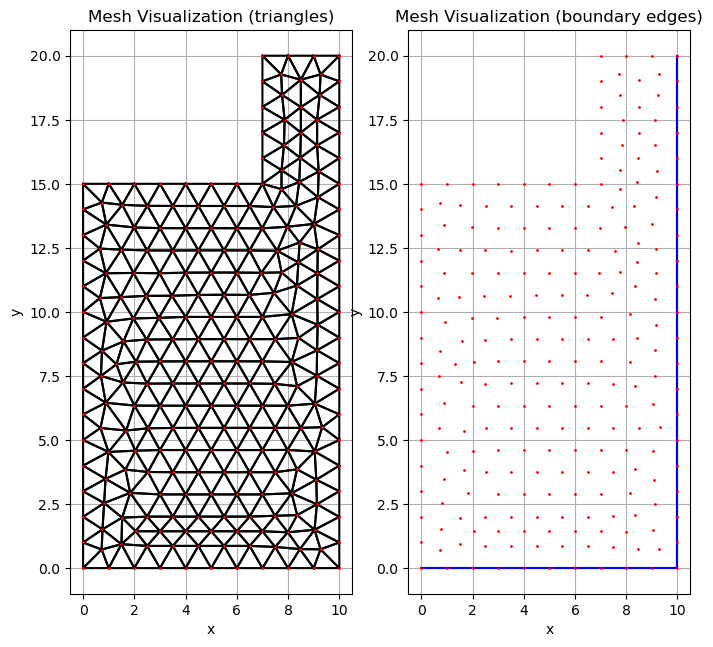

In [18]:
# Read mesh from file
mesh = meshio.read("Breakwater.msh")

# Extract node coordinates and triangle connectivity
points = mesh.points[:, :2]  # (x, y)
triangles = mesh.get_cells_type("triangle")
edges = mesh.get_cells_type("line") # edges on the left boundary

# Plot triangles
fig, ax = plt.subplots(1,2, figsize=(8, 8))
for tri in triangles:
    coords = points[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    ax[0].plot(coords[:, 0], coords[:, 1], 'k-')
ax[0].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[0].set_aspect('equal')
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Mesh Visualization (triangles)")
ax[0].grid(True)

# Plot edges
for edge in edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'blue')
ax[1].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[1].set_aspect('equal')
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Mesh Visualization (boundary edges)")
ax[1].grid(True)
plt.show()


In [22]:
# Defining a function for the coordinates and the quadrature points for 1 or 3 points
def GaussPoints(points=1):
    if points == 1:
        # 1-point quadrature
        qp = np.array([[1/3, 1/3]])
        weights = np.array([0.5])
    elif points == 3:
        qp = np.array([[1/6, 1/6], [2/3, 1/6], [1/6, 2/3]])
        weights = np.array([1/6, 1/6, 1/6]) 
    else:
        raise NotImplementedError("Only order 1 and 2 implemented")
    return qp, weights

In [23]:
#Testing Triangle

def f(x, y):
    return x * y

gps1, weights1 = GaussPoints(1)
int1 = sum(f(gps1[i, 0], gps1[i, 1]) * weights1[i] for i in range(len(weights1)))
print("Integral of f(x,y) over the triangle", int1, "should be:", 1/24)

gps3, weights3 = GaussPoints(3)
int3 = sum(f(gps3[i, 0], gps3[i, 1]) * weights3[i] for i in range(len(weights3)))
print("Integral of f(x,y) over the triangle", int3, "should be:", 1/24)


Integral of f(x,y) over the triangle 0.05555555555555555 should be: 0.041666666666666664
Integral of f(x,y) over the triangle 0.041666666666666664 should be: 0.041666666666666664


In [24]:
# Defining af function for the creation of the shape functions
def shape_functions(qp):
    # Linear shape functions on triangle
    N = []
    dN_dxi = []
    for xi, eta in qp:
        N.append(np.array([1 - xi - eta, xi, eta]))
        dN_dxi.append(np.array([[-1, -1], [1, 0], [0, 1]]))
    return np.array(N), np.array(dN_dxi)

In [25]:
# Function to define the elsaticity tensor
def elasticity_tensor(E, nu, plane_stress=True):
    if plane_stress:
        C = E / (1 - nu**2) * np.array([
            [1, nu, 0],
            [nu, 1, 0],
            [0, 0, (1 - nu)/2]
        ])
    else:  # Plane strain
        C = E / ((1 + nu)*(1 - 2*nu)) * np.array([
            [1 - nu, nu, 0],
            [nu, 1 - nu, 0],
            [0, 0, (1 - 2*nu)/2]
        ])
    return C

In [26]:
# Function to define the element stiffness matrix
def element_stiffness(coords, C, qp, weights, dN_dxi):
    Ke = np.zeros((6, 6))
    for i, (xi_eta, w) in enumerate(zip(qp, weights)):
        J = coords.T @ dN_dxi[i]
        detJ = np.linalg.det(J)
        invJ = np.linalg.inv(J)
        dN_dx = dN_dxi[i] @ invJ

        B = np.zeros((3, 6))
        for a in range(3):
            B[0, 2*a] = dN_dx[a, 0]
            B[1, 2*a+1] = dN_dx[a, 1]
            B[2, 2*a] = dN_dx[a, 1]
            B[2, 2*a+1] = dN_dx[a, 0]

        Ke += B.T @ C @ B * detJ * w
    return Ke

In [27]:
# Function to compute the element mass per element
def element_mass(coords, density, N, weights):
    Me = np.zeros((6, 6))
    for i, w in enumerate(weights):
        Ni = N[i]
        Ni_matrix = np.zeros((2, 6))
        Ni_matrix[0, 0::2] = Ni
        Ni_matrix[1, 1::2] = Ni

        J = coords.T @ dN_dxi[i]
        detJ = np.linalg.det(J)

        Me += density * (Ni_matrix.T @ Ni_matrix) * detJ * w
    return Me
